# Import libraries

In [27]:
from pathlib import Path
import subprocess, os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
max_nr_pcs = 200

In [1]:
# Paths
plink2   = "/home/mat2m10/code/mat2m10/chasm/plink2"
data_dir = Path("/home/mat2m10/code/mat2m10/chasm/data/1000G")
out_dir  = data_dir / "pca"; out_dir.mkdir(exist_ok=True)

# Optional: speed up temp I/O if you have a fast SSD scratch
os.environ["TMPDIR"] = "/tmp"  # change to a fast NVMe path if you have one

# Memory/threads knobs (adjust to your box)
threads = "8"
memory  = "12000"  # MB (leave some headroom)

# Filenames
pgen = data_dir / "all_phase3.pgen"
pvar = data_dir / "all_phase3.pvar"
psam = data_dir / "phase3_corrected.psam"

clean_prefix  = data_dir / "all_phase3_clean"
common_prefix = data_dir / "all_phase3_common"          # NEW: common, autosomal subset
prune_prefix  = out_dir   / "all_phase3_common.prune"
pca_prefix    = out_dir   / "all_phase3_common.PCA"

# 0) One-time clean to fix IDs / biallelic SNPs (same as before)
subprocess.run([
    plink2,
    "--pgen", str(pgen),
    "--pvar", str(pvar),
    "--psam", str(psam),
    "--set-all-var-ids", "@:#:$r:$a",
    "--new-id-max-allele-len", f"{max_nr_pcs}", "missing",
    "--snps-only", "just-acgt",
    "--max-alleles", "2",
    "--rm-dup", "exclude-mismatch",
    "--make-pgen",
    "--memory", memory,
    "--threads", threads,
    "--out", str(clean_prefix)
], check=True)

# 1) FAST: restrict to autosomes + common SNPs (MAF>=0.05) with light QC
subprocess.run([
    plink2, "--pfile", str(clean_prefix),
    "--autosome",
    "--maf", "0.05",
    "--geno", "0.01",
    "--hwe", "1e-6", "midp",
    "--make-pgen",
    "--memory", memory,
    "--threads", threads,
    "--out", str(common_prefix)
], check=True)

# 2) HARDER pruning to land ~80–150k SNPs (tweak if you want more/less)
subprocess.run([
    plink2, "--pfile", str(common_prefix),
    "--indep-pairwise", f"{max_nr_pcs}" "50", "0.1",   # <- key speedup
    "--memory", memory,
    "--threads", threads,
    "--out", str(prune_prefix)
], check=True)

# 3) PCA (exact supports >100 PCs; still fast on ~100k SNPs)
subprocess.run([
    plink2, "--pfile", str(common_prefix),
    "--extract", str(prune_prefix) + ".prune.in",
    "--pca", f"{max_nr_pcs}",
    "--memory", memory,
    "--threads", threads,
    "--out", str(pca_prefix)
], check=True)

PLINK v2.0.0-a.7LM 64-bit Intel (1 Sep 2025)       cog-genomics.org/plink/2.0/
(C) 2005-2025 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3_clean.log.
Options in effect:
  --make-pgen
  --max-alleles 2
  --memory 12000
  --new-id-max-allele-len 200 missing
  --out /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3_clean
  --pgen /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3.pgen
  --psam /home/mat2m10/code/mat2m10/chasm/data/1000G/phase3_corrected.psam
  --pvar /home/mat2m10/code/mat2m10/chasm/data/1000G/all_phase3.pvar
  --rm-dup exclude-mismatch
  --set-all-var-ids @:#:$r:$a
  --snps-only just-acgt
  --threads 8

Start time: Thu Sep 11 12:42:56 2025
15841 MiB RAM detected, ~15016 available; reserving 12000 MiB for main
workspace.
Using up to 8 compute threads.
2504 samples (1270 females, 1233 males, 1 ambiguous; 2497 founders) loaded from
/home/mat2m10/code/mat2m10/chasm/data/1000G/phase3

/tmp/ipykernel_12569/2229378474.py:78: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  pcs_df = pd.read_csv(eigvec_path, delim_whitespace=True, header=None)


In [11]:
eigvec_path = "/home/mat2m10/code/mat2m10/chasm/data/1000G/pca/all_phase3_common.PCA.eigenvec"

pcs_df = pd.read_csv(
    eigvec_path,
    sep=r"\s+",    # split on any whitespace
    header=None,
    skiprows=1     # skip the header line
)
pcs_df.columns = ["FID"] + [f"PC{i}" for i in range(1, pcs_df.shape[1])]
pcs_df

,FID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,HG00096,-0.011583,0.027266,0.011960,0.017402,-0.002826,-0.001475,0.006970,0.001830,-0.024722,...,-0.019225,-0.005681,0.000046,0.006257,-0.015859,-0.008490,0.001968,0.004078,-0.006488,-0.006309
1,HG00097,-0.011306,0.027269,0.011363,0.017042,-0.000256,0.000669,0.008793,-0.001357,-0.028089,...,-0.007352,0.033442,0.000644,0.013115,-0.000578,-0.002701,-0.008841,-0.009368,-0.004871,-0.008819
2,HG00099,-0.011712,0.026766,0.011278,0.015904,0.001041,0.000059,0.013733,-0.002562,-0.025384,...,0.000627,0.012013,0.004639,0.001248,0.008512,-0.014604,0.002158,0.015738,-0.016714,0.007612
3,HG00100,-0.011391,0.027713,0.012725,0.018854,-0.004196,-0.000372,0.005480,0.000936,0.007262,...,-0.017035,-0.012656,-0.007817,-0.007654,-0.000970,0.004135,0.001104,-0.009433,-0.000884,-0.009166
4,HG00101,-0.011239,0.027027,0.011830,0.017332,0.001220,-0.003073,0.011868,0.001882,-0.030110,...,-0.005675,0.004731,-0.011821,-0.012825,0.005341,-0.007842,0.006539,-0.008706,-0.001713,-0.004402
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2499,NA21137,-0.010268,0.007140,-0.038670,-0.014234,-0.001880,0.001880,0.005208,-0.000677,0.023306,...,0.014568,0.005229,-0.013871,-0.010035,0.017747,-0.018003,-0.012556,0.017319,-0.010796,-0.013961
2500,NA21141,-0.010860,0.007364,-0.038665,-0.013475,0.002868,0.004553,0.010134,0.002965,0.041227,...,-0.001268,0.010784,0.020312,-0.000547,0.006890,0.024476,-0.013241,-0.002346,-0.013162,-0.002303
2501,NA21142,-0.010450,0.006945,-0.038490,-0.012896,0.004474,0.006116,0.008317,0.001911,0.038895,...,-0.010920,0.004001,0.000559,-0.005525,-0.001286,0.014387,-0.005896,-0.015316,0.018070,-0.015180
2502,NA21143,-0.010772,0.006275,-0.038852,-0.013199,0.002469,0.006504,0.007908,-0.001294,0.037605,...,0.006565,-0.010706,0.001791,0.005323,-0.027016,0.014877,-0.010754,-0.012228,0.004326,-0.010356


In [17]:
pcs_df.to_pickle(f"{data_dir}/pca/1000G_{max_nr_pcs}_PCs.pkl")

In [22]:
path_1K = "../../data/1000G/"
chroms = os.listdir(f"{path_1K}/chunks")
for chrom in chroms:
    path_chrom = f"{path_1K}/chunks/{chrom}"
    chunks = os.listdir(path_chrom)

    first = pd.read_pickle(f"{path_chrom}/{chunks[0]}")
    split_cols = first['IID'].str.split('_', n=1, expand=True)
    first['subpopulation'] = split_cols[1]
    first['population']    = split_cols[0]
    iid_idx = first.columns.get_loc('IID')
    for col in ['population', 'subpopulation'][::-1]:
        first.insert(iid_idx + 1, col, first.pop(col))

In [25]:
pcs_df['population'] = first['population']

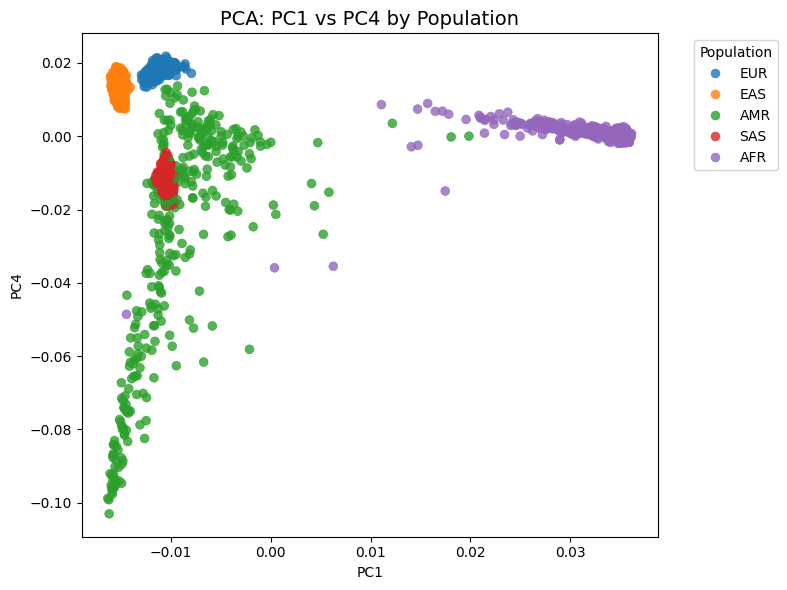

In [37]:
pc_x = 1
pc_y = 4

# assuming your dataframe is called df
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=pcs_df,
    x=f"PC{pc_x}",
    y=f"PC{pc_y}",
    hue="population",
    s=40,           # point size
    alpha=0.8,      # transparency
    edgecolor=None  # cleaner look
)

plt.title(f"PCA: PC{pc_x} vs PC{pc_y} by Population", fontsize=14)
plt.xlabel(f"PC{pc_x}")
plt.ylabel(f"PC{pc_y}")
plt.legend(title="Population", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()